# map dashboard with bokeh and panel

## interactions

- [x] selection of points: get selected dataframe
- [x] get a tree from subset of samples
    - requires snp matrix for samples
    - use encoded snps in the database
- [x] show clustermap of snp distances
- [ ] closely related isolates only
- [x] draw selected samples from multiselect on map
- [x] fix aspect ration for manual zoom
- [x] show SNP data?
- [ ] show movement type data?

In [1]:
import sys,os,shutil,subprocess
import glob
import json
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import sqlite3
import toytree, toyplot
import random
from snipgenie import trees, tools, snp_typing, plotting
import geopandas as gpd

/usr/local/lib/python3.9/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
css = '''
.bk.panel-widget-box {
  background: #f0f0f0;
  border-radius: 5px;
  border: 1px black solid;
}
'''

In [3]:
from collections import OrderedDict
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models import (DataTable, GeoJSONDataSource, ColumnDataSource, HoverTool, renderers,
                          Label, LabelSet, CustomJS, MultiSelect, Dropdown, Div, Range1d, Arrow, VeeHead)
from bokeh.transform import factor_cmap, factor_mark
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension(raw_css=[css])
pn.extension('tabulator')

Loading BokehJS ...

In [4]:
tree_style = {
    "layout":'r',
    "edge_type": 'p',
    "edge_style": {
        "stroke": 'black',
        "stroke-width": 2,
    },
    "tip_labels": True,
    "tip_labels_align": True,
    "tip_labels_colors": 'black',
    "tip_labels_style": {
        "font-size": "14px"
    },
    "node_labels": False,
    "node_sizes": 12,
    "node_colors": toytree.colors[2],
    "node_markers":"c",
    "use_edge_lengths":True,
}

template = """
{% extends base %}

<!-- goes in body -->
{% block postamble %}
<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css">
{% endblock %}

<!-- goes in body -->
{% block contents %}
{{ app_title }}
<p>This is a Panel app with a custom template allowing us to compose multiple Panel objects into a single HTML document.</p>
<br>
<div class="container">
  <div class="row">
    <div class="col-sm">
      {{ embed(roots.A) }}
    </div>
    <div class="col-sm">
      {{ embed(roots.B) }}
    </div>
  </div>
</div>
{% endblock %}
"""

## test meta data 

In [5]:
parcels = gpd.read_file('/storage/btbgenie/monaghan/metadata/lpis_monaghan_10km_buff.shp').set_crs('EPSG:29902')
parcels = parcels.to_crs(epsg=3395)

In [6]:
#TEST DATA
meta = pd.read_csv('ireland_test_data.csv')
meta = meta.fillna('')
snpcols=['snp3','snp5','snp12','snp20','snp50']
for i in snpcols:
    meta[i]=meta[i].astype(str)

In [7]:
#ACTUAL DATA
#meta2 = pd.read_csv('/storage/btbgenie/monaghan/metadata/master.csv')
meta2 = gpd.read_file('/storage/btbgenie/monaghan/metadata/centroids.shp')
meta2['sample'] = meta2.SeqID
for i in snpcols:
    meta2[i]=meta2[i].astype(str)

## encode SNPs field that is used for dist matrix

In [8]:
snpm = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/core.txt',sep=' ').set_index('pos').T
snpm = snpm.fillna('N')
meta2['snps'] = snpm.apply(snp_typing.encode_snps,1)

In [9]:
meta2

,HERD_NO,SeqID,ANIMAL_ID,County,Species,SB,class_2019,Aliquot,snp3,snp5,snp7,snp12,snp20,snp50,snp100,geometry,sample,snps
0,R1020793,19-4235,IE291019470197,Monaghan,Bovine,SB0142,B,TB19-004235,-1,-1,43,34,31,18,11,POINT (273057.014 306596.060),19-4235,NaN
1,R1030438,19-4022,372218238731193,Monaghan,Bovine,SB0140,F,TB19-004022,-1,-1,-1,-1,-1,6,5,POINT (284663.972 305126.703),19-4022,NaN
2,R1050803,3413,IE291066381537,Monaghan,Bovine,SB0142,D,TB19-003413,-1,-1,-1,-1,-1,18,11,POINT (282199.881 307573.439),3413,NaN
3,R1050803,19-7323,IE291066381537,Monaghan,Bovine,SB0140,D,TB19-007323,-1,3,5,3,1,3,2,POINT (282199.881 307573.439),19-7323,NaN
4,R105106X,1477,IE291046070237,Monaghan,Bovine,SB0142,B,TB19-001477,-1,32,33,28,27,15,11,POINT (281475.515 306754.790),1477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,None,307-Bov-2013-2.142,None,NI,Bovine,SB0142,None,None,21,26,26,25,21,16,11,POINT (285710.963 337511.237),307-Bov-2013-2.142,NaN
212,None,324-Bov-2015-2.142,None,NI,Bovine,SB0142,None,None,-1,-1,-1,-1,-1,15,11,POINT (239004.765 333210.401),324-Bov-2015-2.142,NaN
213,None,346-Bov-2016-5.140,None,NI,Bovine,SB0140,None,None,-1,-1,-1,10,6,8,9,POINT (255706.873 355613.338),346-Bov-2016-5.140,NaN
214,None,364-Bov-2017-3.140,None,NI,Bovine,SB0140,None,None,-1,-1,-1,24,22,9,7,POINT (281010.342 336711.089),364-Bov-2017-3.140,NaN


## movement

In [10]:
allmov = pd.read_csv('/storage/btbgenie/monaghan/metadata/movement/all_moves_from_not_sl.csv',parse_dates=['move_date','bd_back','bd_forward'])
cols=['SeqID', 'moves', 'tag', 'moved','risky_move']
ms = allmov.groupby('tag').agg({'move_from':np.size}).reset_index().drop_duplicates('tag')
ms['moved']=ms.move_from>0

In [11]:
#read from db
#con = sqlite3.connect("test.sqlite")
#cur = con.cursor()
#df = pd.read_sql_query("SELECT * from isolates", con)

In [12]:
species_colors = {'Cow':'green', 'Badger':'blue', 'Deer':'red','Dog':'orange'}
c,sb_colors = plotting.get_color_mapping(meta, 'SB', cmap=None)
c,county_colors = plotting.get_color_mapping(meta, 'county', cmap=None)
c,snp_colors = plotting.get_color_mapping(meta, 'snp12', cmap=None)
c,snp50_colors = plotting.get_color_mapping(meta, 'snp50', cmap=None)

cmaps = {'species': species_colors,'SB':sb_colors,'county':county_colors,'snp12':snp_colors,'snp50':snp50_colors}
providers = ['CARTODBPOSITRON','STAMEN_TERRAIN','OSM','ESRI_IMAGERY']

In [13]:
def sample_tree(n=10):

    import toytree
    tre = toytree.rtree.coaltree(n)
    ## assign random edge lengths and supports to each node
    for node in tre.treenode.traverse():
        node.dist = np.random.exponential(1)
        node.support = int(np.random.uniform(50, 100))

    canvas,axes,mark = tre.draw(
                    width=350,
                    height=500,
                    scalebar=True, **tree_style)
    toyplot.html.render(canvas, "tree.html")
    return

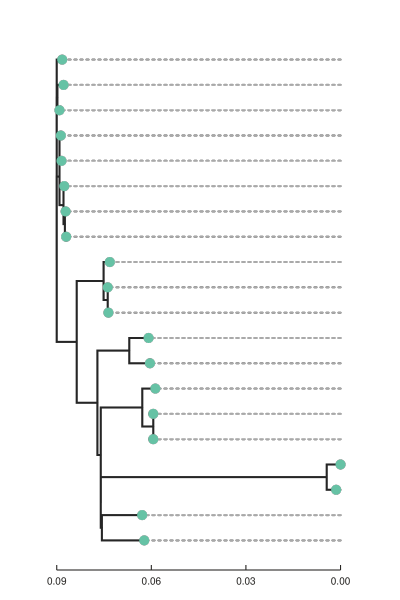

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="700.0px" height="360.0px" viewBox="0 0 700.0 360.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td38c20dda7a44de2820a33e630604b99"> TB19-004994 TB19-006148 59-6110 2061 TB19-011618 2809 TB19-006791 ERR125627 362p TB19-006428 TB19-008982 TB19-003030 TB19-009477 TB20-001041 TB20-001911 48-MBovis TB20-002585 TB19-005831 TB19-008912 TB20-002813

In [14]:
def get_tree(df):
    """Get a tree from a selection of samples
       uses encoded snp data from dataframe/db to make a distance matrix
    """
    
    #decode snps
    snpmat = df.snps.apply(snp_typing.decode_snps)
    snpmat.index = df.name
    #print (snpmat[:4])  
    tre = snp_typing.tree_from_snps(snpmat.T)
    return tre

def draw_tree(tre, df, colorby=None, layout='r', font_size=10, node_size=8, root=None, labels=True, **kwargs):
    """draw the tree with given options"""

    if root not in ['',None]:
        tre = tre.root(root)
    tipnames = tre.get_tip_labels()
    node_colors = None
    node_sizes = None
    if colorby not in ['',None]:
        mapping = dict(zip(df.name,df[colorby]))
        colormap =  cmaps[colorby]
        tip_colors = [colormap[mapping[i]] if (i in mapping and i!='') else 'gray' for i in tipnames]
        node_sizes=[0 if i else node_size for i in tre.get_node_values(None, 1, 0)]
        node_colors = [colormap[mapping[n]] if n in mapping else 'gray' for n in tre.get_node_values('name', True, True)]
        if len(tipnames)>40 or labels == False:         
            tipnames = ['' for i in tipnames]  
    else:
        tip_colors = None
    tip_labels_style={      
            "font-size": "%spx" %font_size,
            "-toyplot-anchor-shift": "13px",
        }
    #render to html
    canvas, axes, mark = tre.draw(tip_labels=tipnames, tip_labels_colors=tip_colors,tip_labels_style=tip_labels_style,
                                  layout=layout,node_colors=node_colors,node_sizes=node_sizes,node_hover=True,
                                  scalebar=True, width=400, height=600, **kwargs);   
    toyplot.html.render(canvas, "tree.html");
    return canvas

tre = get_tree(meta.sample(20))
draw_tree(tre,meta,'snp12',node_size=10,layout='r', labels=False,tip_labels_align=True)

In [15]:
def dist_matrix(df):
    """Distance matrix from nuc SNP matrix"""
     
    snpmat = df.snps.apply(snp_typing.decode_snps)
    names = snpmat.index = df.name
    M=[]
    for i,r in snpmat.iterrows():
        x=[]
        s1 = ''.join(r)
        for i,r in snpmat.iterrows():
            s2=''.join(r)        
            m = [1 for x,y in zip(s1,s2) if x!=y]
            #print (m)
            x.append(sum(m))
        M.append(x)
    M = pd.DataFrame(M,index=names,columns=names)
    return M

dist_matrix(meta[:4])

name,ERR125617,ERR125622,ERR125598,ERR125612
name,,,,
ERR125617,0,138,140,404
ERR125622,138,0,48,406
ERR125598,140,48,0,408
ERR125612,404,406,408,0


In [17]:
def dist_plot(dist):
    import seaborn as sns
    
    annot=False
    if len(dist)<12:
        annot=True
    g=sns.clustermap(dist,annot=annot,fmt='.0f',xticklabels=True,yticklabels=True,cmap='Blues',figsize=(10,10))
    return g.fig

#m=dist_matrix(meta[80:90])   
#f=dist_plot(m)

In [18]:
def wgs84_to_web_mercator(df, lon="LON", lat="LAT"):

      k = 6378137
      df["x"] = df[lon] * (k * np.pi/180.0)
      df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
      return df

In [19]:
def get_cluster_samples(cl, col='snp12'):
    df=meta[meta[col].isin(cl)]
    return list(df.name)

In [20]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

In [21]:
def bokeh_geodataframe(gdf, p):
    
    geosource = get_geodatasource(gdf)    
    p.patches('xs','ys', source=geosource, fill_alpha=.4, line_width=0.5, fill_color='red', line_color='black')
    return

In [27]:
def test_map(df):
    tile_provider = get_provider(CARTODBPOSITRON)
    # range bounds supplied in web mercator coordinates
        
    df['size'] = 10    
    source = ColumnDataSource(df)
    #draw figure
    p = figure()  
    p.add_tile(tile_provider)
    SPECIES = ['Bovine','Badger','Deer']
    MARKERS = ['circle', 'triangle','square']
    p.scatter(x='x', y='y', size='size', alpha=0.9, color='red',source=source,
            marker=factor_mark('species', MARKERS, SPECIES))
    
    p.add_tile(tile_provider)
    return p

def connect_points(coords, p):
    #p.line(coords, color="black", line_width=4)  
    for c in coords:
        p.add_layout(Arrow(end=VeeHead(size=10),
                       x_start=c[0], y_start=c[1], x_end=c[2], y_end=c[3]))

df=meta[:8].copy()
df = wgs84_to_web_mercator(df, lon="LONG", lat="LAT")
#print (df[['sample','x','y','LONG','LAT']])
p=test_map(df)
a=[df.iloc[0].x,df.iloc[0].y,df.iloc[1].x,df.iloc[1].y]
b=[df.iloc[1].x,df.iloc[1].y,df.iloc[2].x,df.iloc[2].y]
coords=[a,b]
print (coords)
connect_points(coords, p)
#bokeh_geodataframe(parcels[:300], p)
show(p)

[[-751874.4569558809, 7231371.356317318, -746450.0481398777, 7248811.917580913], [-746450.0481398777, 7248811.917580913, -710840.2055092382, 7255704.95051292]]


In [23]:
def bokeh_map(df=None, long=None, lat=None, height=600,
              tile_provider='CARTODBPOSITRON', colorby='county',
              labels=None):
    """Bokeh map"""
    
    tile_provider = get_provider(tile_provider)
    tools = "pan,wheel_zoom,hover,tap,lasso_select,reset,save"
    sizing_mode='stretch_both'
    
    # range bounds supplied in web mercator coordinates
    k = 6378137
    if lat == None:
        lat = 53.5
    if long == None:
        long = -7

    #get coords
    x = long * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k    
    df = wgs84_to_web_mercator(df, lon="LONG", lat="LAT")
    SPECIES = ['Bovine','Badger','Deer']
    MARKERS = ['circle', 'triangle','square']
    colormap = cmaps[colorby]
    df['color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]] 
    df['label'] = ''
    df['size'] = 10
    source = ColumnDataSource(df)
    #draw figure
    p = figure(tools=tools, #x_range=(x-200000, x+200000), y_range=(y-200000, y+200000),
               #x_axis_type="mercator", y_axis_type="mercator", 
               plot_width=height, plot_height=height, sizing_mode=sizing_mode)   
    p.add_tile(tile_provider)
    p.circle(x='x', y='y', size='size', alpha=0.7, color='color', source=source)       
                #marker=factor_mark('species', MARKERS, SPECIES))
                #, legend_group=colorby)

    labels = LabelSet(x='x', y='y', text='label',text_font_size='10pt',
                     x_offset=5, y_offset=5, source=source, render_mode='canvas')
    p.add_layout(labels)
    
    #p.legend.location = "top_left"
    #p.legend.click_policy="mute"    
    p.toolbar.logo = None
    p.match_aspect = True
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ("name", "@name"),
        ("species", "@species"),
        ("SB", "@SB"),
        ("snp12", "@snp12"),
        ("snp50", "@snp50"),
        #("nearest", "@nearest"),
        ("county", "@county"),
    ])
    return p


In [24]:
def map_dash(df):
    """Map dashboard"""

    names = sorted(list(df['sample'].unique()))
    snp12 = sorted(list(df.snp12.unique()))
    tre = None
    sel = None
    cols = df.columns[:6]
    cats=['county','species','snp12','snp50','SB']
    labels=['','name','snp12']
    counties=['All','Wicklow','Monaghan','NI']
    map_pane = pn.pane.Bokeh(width=400)    
    tree_pane = pn.pane.HTML(width=300)
    plot_pane = pn.pane.Matplotlib(height=500)
    
    tile_select = pnw.Select(name='tile layer',options=providers,width=200)
    colorby_select = pnw.Select(name='color by',options=cats,width=200)
    label_select = pnw.Select(name='label',options=labels,width=200)
    name_select = pnw.MultiSelect(name='name',options=names,size=6,width=200)
    cluster_select = pnw.MultiSelect(name='cluster',options=snp12,size=6,width=200)
    county_select = pnw.Select(name='county',options=counties,width=200)
    show_parcels_box = pnw.Checkbox(name="show land parcels",value=False,width=200)
    
    #buttons
    reset_btn = pnw.Button(name='Reset', button_type='primary',width=200)    
    related_btn = pnw.Button(name='Find Related Isolates', button_type='primary',width=200)
    related_clusters_btn = pnw.Button(name='Related Clusters', button_type='primary',width=200)    
    moves_btn = pnw.Button(name='Show Moves', button_type='primary',width=200)
    outliers_btn = pnw.Button(name='Find outliers', button_type='primary',width=200)
    help_btn = pnw.Button(name='Help', button_type='primary',width=200)
    
    style1 = {'background':'#f5f5d6','padding':'5px','font':'monospace'}
    info_pane = pn.pane.HTML(style=style1,width=200, height=200,sizing_mode='stretch_both')    
    df_pane = pn.pane.DataFrame(df[cols],width=500,height=200,sizing_mode='scale_both',max_rows=20,index=False)    
    snps_pane = pnw.Tabulator()
    meta_pane = pnw.Tabulator(df[cols],pagination='remote', page_size=20, width=500,height=600)
    
    #settings pane
    tree_layout_select = pnw.Select(name='tree layout',options=['r','c','d'],width=200)
    root_select = pnw.Select(name='root on',options=[''],width=200)    
    tip_align_box = pnw.Checkbox(name="tip labels align",value=False)
    edge_type_select = pnw.Select(name= "edge type",options=['p','b','c'],width=100)
    node_size_entry = pnw.IntInput(name="tree node size", step=1, start=1, end=30, value=8)
    point_size_entry = pnw.IntInput(name="map point size", step=1, start=2, end=30, value=10)
    settings_pane = pn.Column(tree_layout_select,root_select,tip_align_box,edge_type_select,node_size_entry,point_size_entry,width=100)
    left_tab_pane = pn.Tabs(('tree', tree_pane), ('dists',plot_pane), ('dist matrix',snps_pane), ('meta', meta_pane), ('settings',settings_pane), ('debug',info_pane))

    empty_pane = pn.pane.HTML(width=300,style=style1,sizing_mode='scale_height')
    empty_pane.object = 'test'
    
    loading = pn.indicators.LoadingSpinner(value=False, width=100, height=100)
    
    def update_info(attr,new,old):     
        #print(new,old)
        info_pane.object = '<p>%s,%s</p>' %(int(new),int(old))
        
    def zoom_to_points(sel, p, pad=200000):
        #zoom with aspect conserved
        if len(sel)==1:
            x=sel.iloc[0].x
            y=sel.iloc[0].y
        else:  
            x=-779236
            y=7076025
        p.x_range.update(start=x-pad,end=x+pad)
        p.y_range.update(start=y-pad,end=y+pad)
        return
    
    def items_selected(event):
        
        global tre, sel
        clusters = cluster_select.value
        if len(clusters)==0:
            names = name_select.value
        else:
            names = get_cluster_samples(clusters)  
        
        root_select.options = ['']+names
        info_pane.object = '\n'.join(names)
        p = map_pane.object
        source = p.renderers[1].data_source        
        colorby = colorby_select.value
        colormap = cmaps[colorby]
        df['color'] = [colormap[i] if i in colormap else 'gray' for i in df[colorby]]
        df['size'] = point_size_entry.value
        #selected data
        sel = df[df.name.isin(names)]
        df_pane.object = sel[cols]
        #show these points only on map      
        source.data = dict(sel)
        
        #draw parcels?
        if show_parcels_box.value==1:
            lp = parcels.sample(200) #[lpis_p.SPH_HERD_N.isin(sel.HERD_NO)]
            bokeh_geodataframe(lp, p)
            
        #zoom to points selected
        zoom_to_points(sel, p)
        update_tile()
        
        #get a tree
        if len(sel)>=3:
            loading.value = True
            tre = get_tree(sel)
            canvas = draw_tree(tre, sel, colorby, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,
                               root=root_select.value)
            tree_pane.object = canvas         
            #dist matrix
            m = dist_matrix(sel)     
            plot_pane.object = dist_plot(m)
            snps_pane.object = m
            loading.value = False
        else:
            tree_pane.object = ''           
            snps_pane.object = ''
        return
    
    def county_selected(event):
        
        global sel
        county = county_select.value
        if county == 'All':
            sel = df
        else:
            sel = df[df.county==county]
        update_map(event)        
        return
        
    def points_selected(attr,new,old):
        """bokeh callback for lasso"""
        
        global tre
        colorby = colorby_select.value
        ind =[int(n) for n in new]
        sel = df.loc[ind]
        df_pane.object = sel[cols]
        if len(sel)>=3:
            tre = get_tree(sel)
            canvas = draw_tree(tre, sel, colorby_select.value, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,                             
                               root=root_select.value)
            tree_pane.object = canvas
            #dist matrix
            m = dist_matrix(sel)     
            plot_pane.object = dist_plot(m)
            snps_pane.object = m
            loading.value = False
            info_pane.object = sel
        return
            
    def tap_callback(event):
        """tap tool callback"""
        
        p = map_pane.object
        source = p.renderers[1].data_source
        ind = source.selected.indices
        sel = df.loc[ind]
        #df_pane.object = sel[cols]
   
        return

    def find_related_callback(event):
        
        global sel        
        p = map_pane.object
        source = p.renderers[1].data_source
        ind = source.selected.indices       
        sel = df.loc[ind]
        if len(sel)>0:
            names = sel['sample']                 
            sel = find_related(names)
            info_pane.object = sel
        update_map(event)
        return
            
    def find_related(names):
        """Find related isolates"""
        
        cl = df[df.name.isin(names)].snp12.unique()
        sub = df[df.snp12.isin(cl)]
        return sub
    
    def draw_map(event):
        
        global sel
        sel = None
        p = map_pane.object = bokeh_map(df)  
        p.x_range.on_change('start', update_info)
        source = p.renderers[1].data_source
        source.selected.on_change('indices', points_selected)     
        p.on_event('tap',tap_callback)
        tree_pane.object = ''
        plot_pane.object = None
        
        return
    
    def update_tile(event=None):
        
        p = map_pane.object
        p.renderers = [x for x in p.renderers if not str(x).startswith('TileRenderer')]
        rend = renderers.TileRenderer(tile_source= get_provider(tile_select.value))
        p.renderers.insert(0, rend) 
        
    def update_map(event): 
        """Updated colors or labels"""
        global sel,df
        p = map_pane.object
        info_pane.object = '<p>%s,%s</p>' %(p.x_range.start,p.x_range.end)
        source = p.renderers[1].data_source
        colorby = colorby_select.value        
        colormap = cmaps[colorby]
        if sel is not None:
            d = sel
        else:
            d = df            
        d['color'] = [colormap[i] if i in colormap else 'gray' for i in d[colorby]]
        d['size'] = point_size_entry.value
        if label_select.value != '': 
            d['label'] = d[label_select.value]
        else:
            d['label'] = ''
            
        source.data = dict(d)
        update_tree(event)
        return
   
    def update_tree(event): 
        
        global tre
        #use subset of samples if selected
        names = name_select.value
        if tre != None: 
            sel = df[df.name.isin(names)]
            canvas = draw_tree(tre, sel, colorby=colorby_select.value, layout=tree_layout_select.value, 
                               tip_labels_align=tip_align_box.value, edge_type=edge_type_select.value,
                               node_size=node_size_entry.value,
                               root=root_select.value)
            tree_pane.object = canvas
               
    def show_moves(event):        
        
        return

    def connect_points(coords, p):
        
        p.multi_line([[1, 3, 2], [3, 4, 6, 6]], 
             color=["firebrick"], alpha=[0.8], line_width=4)
        
        
    draw_map(None)
    reset_btn.on_click(draw_map)
    moves_btn.on_click(show_moves)
    related_btn.on_click(find_related_callback)
    help_btn.js_on_click(args={'target':'https://github.com/dmnfarrell/btbgenietools' }, code='window.open(target)')
    
    #label_box = pnw.Checkbox(name='Show labels')
    tile_select.param.watch(update_tile,'value')
    colorby_select.param.watch(update_map,'value')
    label_select.param.watch(update_map,'value')
    name_select.param.watch(items_selected,'value')
    cluster_select.param.watch(items_selected,'value')
    county_select.param.watch(county_selected,'value')
    #show_parcels_box.param.watch(update_map,'value')
    tree_layout_select.param.watch(update_tree,'value')    
    root_select.param.watch(update_tree,'value')
    
    #layout dashboard
    app = pn.Column(pn.Row(reset_btn,related_btn,moves_btn,outliers_btn,help_btn), 
                    pn.Row(pn.Column(tile_select,colorby_select,label_select,name_select,cluster_select,county_select,show_parcels_box,
                                     background='whitesmoke',sizing_mode='stretch_height'),
                           pn.Column(map_pane,width=600,sizing_mode='stretch_both'),pn.Column(left_tab_pane,width=350,sizing_mode='stretch_height'),loading),
                                     sizing_mode='stretch_both')
    return app


In [ ]:
map_dash(meta)